<a href="https://colab.research.google.com/github/Neuralwood-Net/face-recognizer-9000/blob/main/notebooks/pretraining_celeba_cnn_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Celeb A Neural Net Test V2
## Deeper network

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Nov 11 10:46:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


### Imports

In [4]:
import time
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

from google.cloud import storage

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Read and prepare the data

In [6]:
from google.cloud import storage


client = storage.Client.from_service_account_json("/content/drive/My Drive/## Project/TDT4173 Deep Learning Project-91d3b469375c.json")

bucket_name = "tdt4173-datasets"
bucket = client.get_bucket(bucket_name)

zipfilename = "/content/celeba/img_align_celeba.zip"
blob_name = "celeba/zips/img_align_celeba.zip"
blob = bucket.get_blob(blob_name)

blob.download_to_filename(zipfilename)

In [8]:
data_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),                                  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    # transforms.Normalize([0.5], [0.5]),
    transforms.Grayscale(num_output_channels=1),
])

image_datasets = {x: datasets.CelebA(
    root="/content",
    split=x,
    target_type="identity",
    transform=data_transforms,
    download=True,
) for x in ["train", "valid"]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].identity


Using downloaded and verified file: /content/celeba/img_align_celeba.zip
Using downloaded and verified file: /content/celeba/list_attr_celeba.txt
Using downloaded and verified file: /content/celeba/identity_CelebA.txt
Using downloaded and verified file: /content/celeba/list_bbox_celeba.txt
Using downloaded and verified file: /content/celeba/list_landmarks_align_celeba.txt
Using downloaded and verified file: /content/celeba/list_eval_partition.txt
Files already downloaded and verified


torch.Size([4, 1, 128, 128])


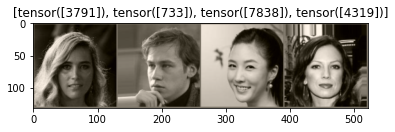

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # mean = np.array([0.5])
    # std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Create functions for training, validation, and evaluation

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            it = tqdm(dataloaders[phase], desc=f"Epoch: {epoch} ({phase})")
            for inputs, labels in it:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                it.set_postfix({"Loss": loss.item()})
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Prepare and train the CNN

In [17]:
import gc
del cnn
gc.collect()

349

In [11]:
class CNN(nn.Module):
    size_after_conv = 32 * 32 * 128
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(   
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.classify = nn.Sequential(
            nn.Linear(self.size_after_conv, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, len(class_names)),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.size_after_conv)
        x = self.classify(x)

        return x

cnn = CNN().to(device)
print(cnn)

CNN(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): ReLU()
    (10): Dropout(p=0.5, inplace=False)
  )
  (classify): Sequential(
    (0): Linear(in_features=262144, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=2048, out_features=162770, bias=True)
  )
)


In [12]:
optimizer = torch.optim.Adam(cnn.parameters())
loss_function = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(cnn, loss_function, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch: 0 (train):   0%|          | 0/40693 [00:00<?, ?it/s]

Epoch 0/24
----------


RuntimeError: ignored

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
images, labels = next(iter(test_loader))

for idx, (image, label) in enumerate(zip(images, labels)):
    pred = int(torch.argmax(cnn(image.view(-1, 1, 64, 64).to(device))))
    convert = {0: "Lars", 1: "Morgan", 2: "Kjartan", 3: "Ingen"}
    
    plt.imshow(image.view(64, 64).cpu(), cmap="gray")
    plt.text(2, 54, f"Image {idx + 1}", fontsize=14, color="white")
    plt.text(2, 58, f"Predicted: `{convert[pred]}`", fontsize=14, color="white")
    plt.text(2, 62, f"Actual   : `{convert[label.item()]}`", fontsize=14, color="white")
    plt.pause(0.05)

In [ ]:
import cv2

In [ ]:
cnn.eval()

class Label:
    def __init__(self, label):
        self.label = label
    
    def item(self):
        return self.label


filename = "/content/lars_5.png"
image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (64, 64)) / 255.0
plt.imshow(image, cmap="gray")
convert = {0: "Lars", 1: "Morgan", 2: "Kjartan", 3: "Ingen"}

pred = int(torch.argmax(cnn(torch.Tensor(image).view(-1, 1, 64, 64).to(device))))
# plt.text(2, 58, f"Predicted: `{convert[pred]}`", fontsize=14, color="white")
# plt.text(2, 62, f"Actual   : `{convert[label.item()]}`", fontsize=14, color="white")

if "morgan" in filename:
    label = Label(1)
elif "lars" in filename:
    label = Label(0)
else:
    label = Label(3)

print(f"Predicted: `{convert[pred]}`" )
print(f"Actual   : `{convert[label.item()]}`")

# plt.imshow(image.view(64, 64).cpu().to_numpy(), cmap="gray")
